In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.callbacks import EarlyStopping

Info about Dataset

In [2]:
train = list(os.walk(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train"))

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [4]:

def dataset(path): 
    images = []
    labels = []
    for folder in os.listdir(path):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train")
images, labels = shuffle(images, labels)

In [5]:
images.shape

(2282, 224, 224, 3)

In [6]:
labels.shape

(2282,)

Data Visualization

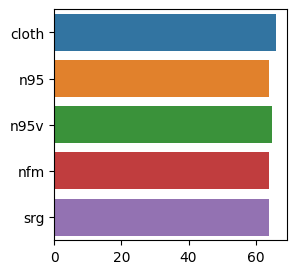

In [7]:
types_of_mask= train[0][1]
no_of_masks = []
for _ in range(1,6):
    no_of_masks.append(len(train[_][0]))
plt.figure(figsize = (3,3))
sns.barplot(y = types_of_mask, x = no_of_masks);

Sample Images

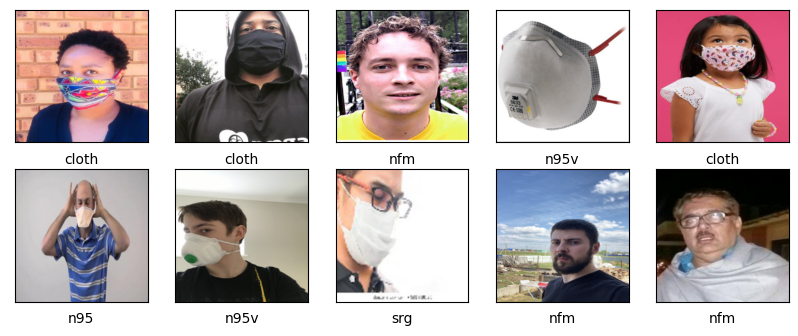

In [8]:
plt.figure(figsize = (10,10))
for _ in range(10):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

Data Augmentation

In [9]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [10]:
train_ds = train_datagen.flow_from_directory(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb")

val_ds = train_datagen.flow_from_directory(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\Mask_Dataset\train",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1828 images belonging to 5 classes.
Found 454 images belonging to 5 classes.


In [11]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


Some augmented images

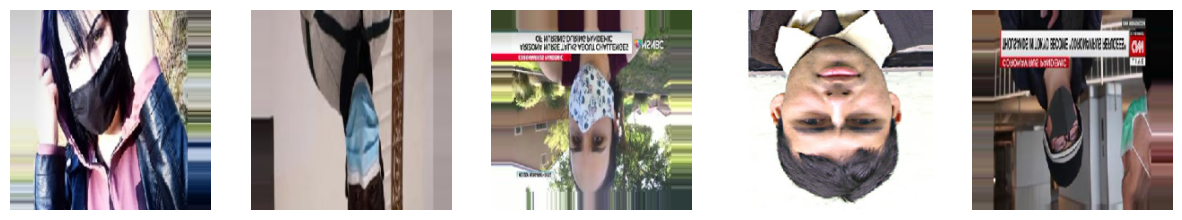

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

Transfer Learning ResNet50

In [14]:
model = applications.ResNet50V2()
inputs = Input(shape=(224, 224, 3))

base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.5)(final_output)
final_output = layers.Dense(64)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dropout(0.3)(final_output)
final_output = layers.Dense(5,activation='softmax')(final_output)

new_model = keras.Model(inputs = base_input , outputs=final_output)
new_model.summary()

102883328/102869336 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [15]:
new_model.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

callback = [early_stopping]

In [17]:
res_hist=new_model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[callback])

Epoch 1/15
29/29 [==============================] - 55s 1s/step - loss: 1.3805 - accuracy: 0.4426 - val_loss: 1.0138 - val_accuracy: 0.5947
Epoch 2/15
29/29 [==============================] - 36s 1s/step - loss: 0.8345 - accuracy: 0.6937 - val_loss: 0.6660 - val_accuracy: 0.7401
Epoch 3/15
29/29 [==============================] - 35s 1s/step - loss: 0.5816 - accuracy: 0.7916 - val_loss: 0.5707 - val_accuracy: 0.7996
Epoch 4/15
29/29 [==============================] - 36s 1s/step - loss: 0.4567 - accuracy: 0.8419 - val_loss: 0.4382 - val_accuracy: 0.8612
Epoch 5/15
29/29 [==============================] - 36s 1s/step - loss: 0.3750 - accuracy: 0.8802 - val_loss: 0.5350 - val_accuracy: 0.8040
Epoch 6/15
29/29 [==============================] - 36s 1s/step - loss: 0.3117 - accuracy: 0.8939 - val_loss: 0.4465 - val_accuracy: 0.8436
Epoch 7/15
29/29 [==============================] - 35s 1s/step - loss: 0.2586 - accuracy: 0.9103 - val_loss: 0.4113 - val_accuracy: 0.8700
Epoch 8/15
29/29 [==

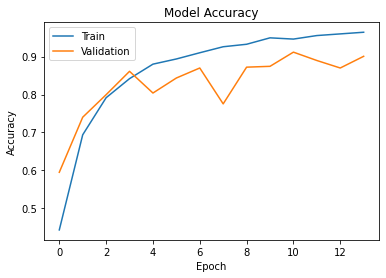

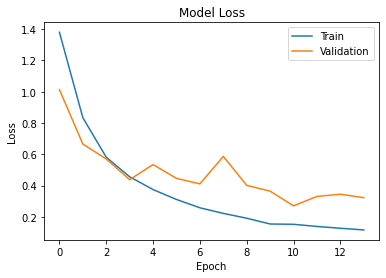

In [18]:
import matplotlib.pyplot as plt
plt.plot(res_hist.history['accuracy'])
plt.plot(res_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


plt.plot(res_hist.history['loss'])
plt.plot(res_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


In [19]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

The given image is of 
Class: 3 
Species: nfm


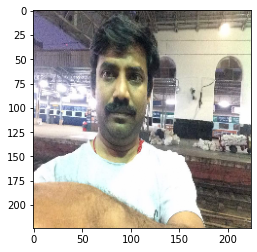

In [20]:
predictor(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test.jpg", new_model)

The given image is of 
Class: 2 
Species: n95v


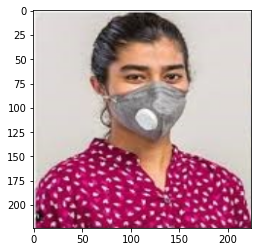

In [21]:
predictor(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test1.jpg", new_model)

The given image is of 
Class: 1 
Species: n95


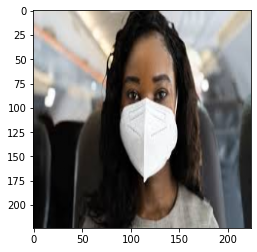

In [22]:
predictor(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test3.jpg", new_model)

The given image is of 
Class: 0 
Species: cloth


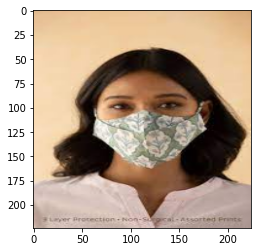

In [23]:
predictor(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test3.jpg", new_model)

The given image is of 
Class: 4 
Species: srg


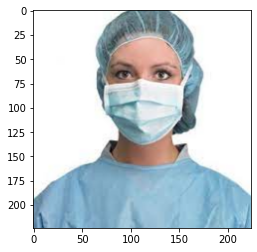

In [24]:
predictor(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test4.jpg", new_model)

Saving the model

In [25]:
new_model.save('Face_Mask_Detection.h5')

Predicting from the saved Model

In [13]:
modelSaved = keras.models.load_model('Face_Mask_Detection.h5') 

In [14]:
frame = cv2.imread(r"D:\3rd Year 5th Sem\LAB\DL Lab\Mask_Final\test.jpg")

In [15]:
frame.shape

(768, 1024, 3)

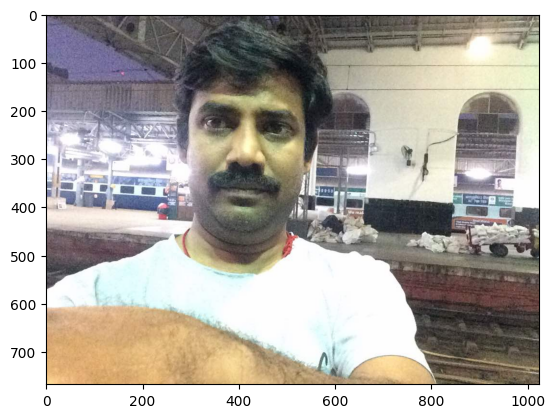

In [16]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [17]:
final_image = cv2.resize(frame,(224,224))
final_image = np.expand_dims(final_image, axis=0) 
final_image = final_image/255.0

In [18]:
Predictions = modelSaved.predict(final_image)

1/1 [==============================] - 4s 4s/step


In [19]:
Predictions.argmax()

3

In [20]:
Predictions

array([[1.3791187e-01, 6.3301479e-05, 3.4685704e-04, 8.5964489e-01,
        2.0330113e-03]], dtype=float32)

In [21]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

Using Haarcascade Frontal Face through openCV and predicting the classes

In [22]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [23]:
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [24]:
gray.shape

(768, 1024)

In [25]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(225,0,0),2)
    faces = faceCascade.detectMultiScale(roi_gray)
    if len(faces)==0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in faces:
            face_roi = roi_color[ey:ey+eh,ex:ex+ew]

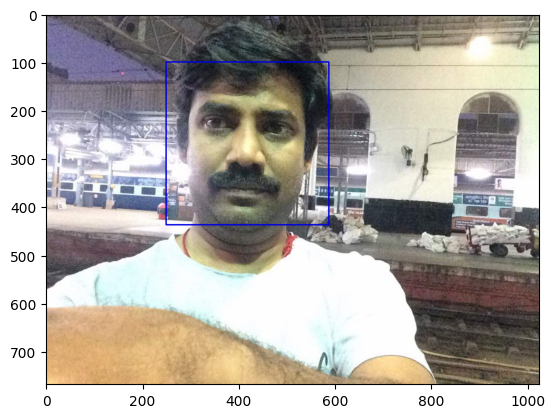

In [26]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

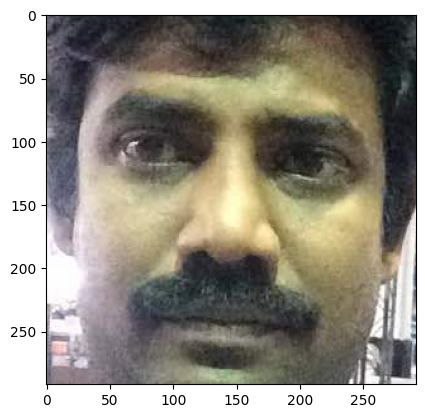

In [27]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [28]:
Predictions = modelSaved.predict(final_image)

1/1 [==============================] - 1s 544ms/step


In [29]:
Predictions

array([[1.3791187e-01, 6.3301479e-05, 3.4685704e-04, 8.5964489e-01,
        2.0330113e-03]], dtype=float32)

In [30]:
Predictions.argmax()

3

In [31]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

Realtime Face mask Classifier 

In [33]:
from turtle import color
import numpy as np
import cv2
from cv2 import rectangle
from cv2 import putText
from grpc import Status
path = 'haarcascade_frontalface_default.xml'
font_scale =1.5
font = cv2.FONT_HERSHEY_PLAIN

rectangle_bgr = (255,255,255)
img = np.zeros((500,500))
text ="Some text in a box!"
(text_width,text_height) = cv2.getTextSize(text,font ,fontScale = font_scale,thickness=1)[0]
text_offset_x =10
text_offset_y = img.shape[0] - 25
box_coords = ((text_offset_x,text_offset_y),(text_offset_x+text_width+2,text_offset_y-text_height-2))
cv2.rectangle(img,box_coords[0],box_coords[1],rectangle_bgr,cv2.FILLED)
cv2.putText(img,text,(text_offset_x,text_offset_y),font,fontScale=font_scale,color=(0,0,0),thickness=1)

cap =cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("cant open webcam")

while True:
    ret,frame=cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(225,0,0),2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print("Face not detected")
        else:
            for(ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey:ey+eh,ex:ex+ew]

    final_image = cv2.resize(face_roi,(224,224))
    final_image = np.expand_dims(final_image, axis=0) 
    final_image = final_image/255.0

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions =modelSaved.predict(final_image)

    font_scale =1.5
    font = cv2.FONT_HERSHEY_PLAIN

    if(np.argmax(Predictions)==0):
        status ="cloth"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==1):
        status ="n95"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==2):
        status ="n95v"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    elif(np.argmax(Predictions)==3):
        status ="nfm"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    else:
        status ="srg"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
        cv2.putText(frame,status,(x1+int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255))
        
    cv2.imshow('Face Mask Type',frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 346ms/step
Face not detected
1/1 [==============================] - 0s 264ms/step
Face not detected
1/1 [==============================] - 0s 190ms/step
Face not detected
1/1 [==============================] - 0s 191ms/step
Face not detected
1/1 [==============================] - 0s 155ms/step
Face not detected
1/1 [==============================] - 0s 183ms/step
Face not detected
1/1 [==============================] - 0s 152ms/step
Face not detected
1/1 [==============================] - 0s 131ms/step
